**SUMBER: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction?select=train.csv**

# Importing Modules and Files

In [1]:
# Modul - modul yang diperlukan
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np, math, warnings
from sklearn.utils import resample
from scipy.stats import skew
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Mengatur lebar dari cell agar memudahkan visualisasi dan analisis
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Menghilangkan warning
warnings.filterwarnings("ignore")

data = pd.read_csv(r"C:\Users\Ezra\Documents\PURWADHIKA\Latihan - Tugas\ML\Classification\train.csv")
submission = pd.read_csv(r"C:\Users\Ezra\Documents\PURWADHIKA\Latihan - Tugas\ML\Classification\sample_submission.csv")

print("Struktur data :")
display(data.head(1))
print("Jumlah data : ", len(data))

Struktur data :


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1


Jumlah data :  381109


**Informasi tiap variabel**
![title](var_info1.jpg)

# Data Manipulating and Cleansing

In [2]:
# Deskripsi data
dataDesc = []
for x in data.columns:
    dataDesc.append([
        x,
        data[x].dtypes,
        data[x].isnull().sum(),
        round((((data[x].isnull().sum()) / (len(data))) * 100), 2),
        len(data[x].unique()),
        data[x].drop_duplicates().sample(2).values
    ])

print("Deskripsi masing - masing kolom :")
display(pd.DataFrame(data = dataDesc, columns = [
    "Columns Name",
    "Data Type",
    "NULL",
    "NULL Percentage",
    "Unique",
    "Unique Samples"
]))

# Drop 'Policy_Sales_Channel' karena tidak diketahui arti tiap nilainya
data.drop("Policy_Sales_Channel", 1, inplace = True)

Deskripsi masing - masing kolom :


,Columns Name,Data Type,NULL,NULL Percentage,Unique,Unique Samples
0,id,int64,0,0.0,381109,"[112058, 303893]"
1,Gender,object,0,0.0,2,"[Male, Female]"
2,Age,int64,0,0.0,66,"[28, 23]"
3,Driving_License,int64,0,0.0,2,"[1, 0]"
4,Region_Code,float64,0,0.0,53,"[3.0, 38.0]"
5,Previously_Insured,int64,0,0.0,2,"[0, 1]"
6,Vehicle_Age,object,0,0.0,3,"[> 2 Years, 1-2 Year]"
7,Vehicle_Damage,object,0,0.0,2,"[Yes, No]"
8,Annual_Premium,float64,0,0.0,48838,"[59934.0, 24101.0]"
9,Policy_Sales_Channel,float64,0,0.0,155,"[7.0, 150.0]"


Variabel _Region Code_ seharusnya berbentuk _object_, bukan _float_ karena sifatnya yang bukan rasio. Selain itu, ada tiga kolom baru yang dibuat (_ageRange_, _vintageMonth_, _genderInt_, _vehicleDamageInt_, dan _vehicleAgeInt_) sebagai hasil konversi nilai aslinya. Dua kolom pertama dilakukan untuk mempermudah visualisasi dan analisis. Sedangkan, tiga kolom terakhir dikonversi agar dapat memperoleh nilai _skewness_ dan menampilkan korelasi.

In [3]:
# Mengubah tipe data 'Region_Code'
data["Region_Code"] = data["Region_Code"].astype(str)

In [4]:
# Binning kolom rentang umur
# Jarak rentang diatur dengan 5 poin. Hal ini dikarenakan 5 tahun adalah angka yang paling ideal.
# Kita ambil contoh rentang 8 / 10 tahun, maka pelanggan dengan umur 20 akan masuk ke kategori 20 - 28 / 20 - 30.
# Hal tersebut tentu sangat tidak realistis mengingat pelanggan dengan umur 20 (baru masih kuliah / baru lulus) belum mempunyai penghasilan tetap layaknya pelanggan dengan usia cukup matang (28 - 30).
# Pada sisi lain, jika jarak terlalu pendek (misal 3 tahun), maka kelompok akan terlalu banyak dan menyulitkan untuk visualisasi.
ageRange, ar = [], range(data["Age"].min(), data["Age"].max(), 5)

for a in data["Age"]:
    count = -1
    for i, r in enumerate(ar):
        count += 1
        try:
            if (r + count) <= a <= (ar[i + 1] + count):
                ageRange.append(f"{r + count} - {ar[i + 1] + count}")
                break
            elif (ar[i + 1] + count + 1) <= a <= (ar[i + 2] + count + 1):
                ageRange.append(f"{ar[i + 1] + count + 1} - {ar[i + 2] + count + 1}")
                break
        except:
            ageRange.append(f"> {r + 1}")
            break
                
data["ageRange"] = ageRange

In [5]:
# Binning 'Vintage' ke dalam bulan
# Konversi dilakukan dengan pembulatan ke bawah.
# Sehingga apabila hari adalah 269 (9 bulan kurang 1 hari), maka bulan dianggap 8
data["vintageMonth"] = data["Vintage"].apply(lambda x : f"{math.floor(x / 30)} bulan")

In [6]:
# Encode jenis kelamin
data["genderInt"] = [0 if x == "Female" else 1 for x in data["Gender"] ]

In [7]:
# Encode 'Vehicle_Damage'
data["vehicleDamageInt"] = [0 if x == "No" else 1 for x in data["Vehicle_Damage"] ]

In [8]:
# Encode 'Vehicle_Age'
vehicleAgeInt = []
for x in data["Vehicle_Age"]:
    if x == "< 1 Year":
        vehicleAgeInt.append(0)
    elif x == "1-2 Year":
        vehicleAgeInt.append(1)
    else:
        vehicleAgeInt.append(2)

data["vehicleAgeInt"] = vehicleAgeInt

In [9]:
print("Struktur data terbaru :")
display(data.head(1))

Struktur data terbaru :


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,ageRange,vintageMonth,genderInt,vehicleDamageInt,vehicleAgeInt
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,217,1,44 - 49,7 bulan,1,1,2


**Tidak ada** kolom yang memiliki missing values. Dengan begitu, tidak perlu dilakukan penyesuaian data.

**Variabel _Policy_Sales_Channel_ dieliminasi karena tidak diketahui apa arti dari setiap nilainya.**

# Business Problem

**-- Diperoleh langsung dari Kaggle (sumber data) --**

Perusahaan asuransi ini sebelumnya bergerak di bidang asuransi kesehatan. Namun, sekarang mereka sedang mencoba merambah ke sektor asuransi kendaraan untuk memperlebar sayap perusahaan. Sekarang ini mereka sedang mencoba mendekati 127.307 (**jumlah _test file_**) pelanggan di asuransi kesehatan mereka dari tahun lalu untuk ditawari asuransi kendaraan. Namun, sebelum dilakukan pendekatan, mereka perlu memprediksi terlebih dahulu bagaimana kecenderungan ketertarikan para pelanggan tersebut ke asuransi baru ini. Hal ini dilakukan agar tipe / cara komunikasi, pemasaran, dan efisiensi waktu dan tenaga dapat diatur sedemikian rupa sehingga efektifitas penjualan dapat dicapai. Dikhawatirkan, bila pemetaan tidak dilakukan maka materi dan waktu perusahaan akan terbuang pada pelanggan yang tidak potensial. **Namun, pertimbangan yang paling krusial sebenarnya adalah konteks persaingan antar perusahaan asuransi kendaraan**. Bila perusahaan tidak dapat memetakan calon pelanggannya, maka dikhawatirkan mereka didekati dan diambil alih oleh perusahaan saingan.

**Untuk menunjang keperluan prediksi, perusahaan menyediakan 381.109 (jumlah *train file*) data pelanggan yang sudah memberikan jawaban terhadap ketertarikannya pada asuransi kendaraan.**

# Goals

Mencari **korelasi** dan membuat **prediksi** ketertarikan pelanggan terhadap asuransi kendaraan perusahaan.

# EDA

## Outliers

In [10]:
# Statistik data
print("Statistik tiap kolom :")
display(data.describe())

Statistik tiap kolom :


,id,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage,Response,genderInt,vehicleDamageInt,vehicleAgeInt
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,0.458210,30564.389581,154.347397,0.122563,0.540761,0.504877,0.609616
std,110016.836208,15.511611,0.046110,0.498251,17213.155057,83.671304,0.327936,0.498336,0.499977,0.567439
min,1.000000,20.000000,0.000000,0.000000,2630.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,95278.000000,25.000000,1.000000,0.000000,24405.000000,82.000000,0.000000,0.000000,0.000000,0.000000
50%,190555.000000,36.000000,1.000000,0.000000,31669.000000,154.000000,0.000000,1.000000,1.000000,1.000000
75%,285832.000000,49.000000,1.000000,1.000000,39400.000000,227.000000,0.000000,1.000000,1.000000,1.000000
max,381109.000000,85.000000,1.000000,1.000000,540165.000000,299.000000,1.000000,1.000000,1.000000,2.000000


Sebenarnya, terdapat _outliers_ pada nilai premi pelanggan. Hal itu pertama kali dapat kita deteksi dari nilai Q3 dan nilai maksimumnya yang sangat jauh. Visualisasi lebih lanjutnya dapat kita lihat dari dua grafik di bawah.

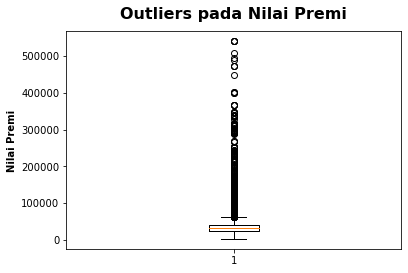

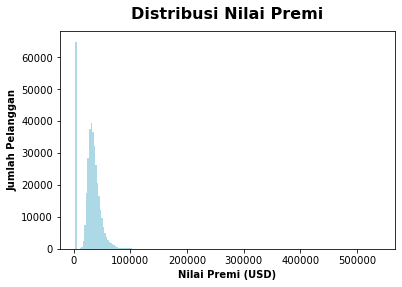

In [11]:
# Outliers dan distibusi pada 'Annual_Premium'
plt.boxplot(data["Annual_Premium"])
plt.title("Outliers pada Nilai Premi", fontdict = {'fontsize': 16,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.03)
plt.ylabel("Nilai Premi", fontdict = {"weight" : "bold"})

plt.show()

plt.hist(data["Annual_Premium"], bins = 200, color = "lightblue")
plt.title("Distribusi Nilai Premi", fontdict = {'fontsize': 16,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.03)
plt.ylabel("Jumlah Pelanggan", fontdict = {"weight" : "bold"})
plt.xlabel("Nilai Premi (USD)", fontdict = {"weight" : "bold"})
plt.show()

Namun, diputuskan untuk tidak mengeliminasi data - data tersebut. Hal ini didasari oleh jumlahnya tidak signifikan. Dapat dilihat dari histogram di atas bahwa nilai premi tersentralisasi sampai rentang kira - kira 70.000 USD, sedangkan nilai di atas itu hampir tidak terlihat. Oleh karena itu, _outliers_ dirasa tidak akan terlalu berpengaruh pada _modelling_ nantinya.

## Distribusi dan Korelasi

In [12]:
# Distribusi ketertarikan
print("Proporsi ketertarikan :")
responsePerc = ((pd.crosstab(data["Response"], columns = "count", normalize = "columns") * 100).round(2)).rename(columns = {"count" : "Presentase"})
responsePerc.columns.name = ""
responsePerc.index = ["Tidak Tertarik", "Tertarik"]
display(responsePerc)

Proporsi ketertarikan :


,Presentase
Tidak Tertarik,87.74
Tertarik,12.26


Data _target_ sangat tidak seimbang dan tidak terdistribusi dengan normal. Maka dari itu, pada saat _modelling_ nanti harus dilakukan penyesuaian.

In [13]:
# Korelasi 'Previously_Insured' dengan ketertarikan
print("Korelasi 'Previously_Insured' dengan ketertarikan :")
prevInsured = ((pd.crosstab(data["Previously_Insured"], data["Response"], normalize = "index") * 100).round(2)).rename(columns = {0 : "Tidak Tertarik", 1 : "Tertarik"})
prevInsured.columns.name = ""
prevInsured.index = ["Belum Memiliki", "Sudah Memiliki"]
display(prevInsured)

Korelasi 'Previously_Insured' dengan ketertarikan :


,Tidak Tertarik,Tertarik
Belum Memiliki,77.45,22.55
Sudah Memiliki,99.91,0.09


Variabel ini sangat rasional dan tidak mengejutkan. Jika pelanggan sudah memiliki asuransi kendaraan, maka kemungkinan untuk dia tertarik terhadap asuransi kendaraan perusahaan sangat kecil. Namun, jika ia belum memiliki asuransi kendaraan pun peluang untuk tidak tertariknya masih tinggi.

In [14]:
# Distribusi kepemilikan izin berkendara
print("Distribusi kepemilikan izin berkendara :")
licenseDist = ((pd.crosstab(data["Driving_License"], columns="count", normalize="columns") * 100).round(2)).rename(columns = {"count" : "Presentase"})
licenseDist.columns.name = ""
licenseDist.index = ["Belum Memiliki", "Sudah Memiliki"]
display(licenseDist)

Distribusi kepemilikan izin berkendara :


,Presentase
Belum Memiliki,0.21
Sudah Memiliki,99.79


Hampir seluruh pelanggan dalam data ini memiliki izin berkendara. Oleh karena itu, tidak perlu lagi mencari korelasinya dengan ketertarikan.

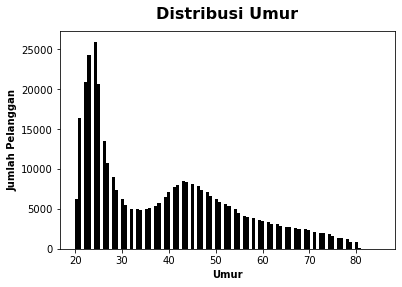

In [15]:
# Distribusi umur
plt.hist(data["Age"], bins = 100, color = "black")
plt.title("Distribusi Umur", fontdict = {'fontsize': 16,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.03)
plt.ylabel("Jumlah Pelanggan", fontdict = {"weight" : "bold"})
plt.xlabel("Umur", fontdict = {"weight" : "bold"})

plt.show()

Pelanggan yang muda mendominasi data.

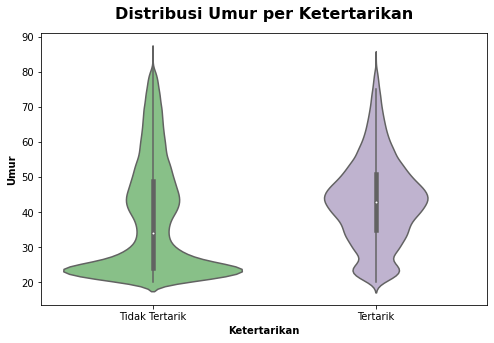

Nilai skewness umur :  0.67 . Artinya, distribusi bersifat moderate positive skewness.

Asumsi normalitas distribusi data tidak terpenuhi. Maka itu, korelasi menggunakan metode Spearman :


,Age,Response
Age,1.00000,0.14436
Response,0.14436,1.00000


In [16]:
# Hubungan antara umur dan ketertarikan
plt.figure(figsize = (8, 5))
ax = sns.violinplot(x = data["Response"], y = data["Age"], palette = "Accent")
plt.title("Distribusi Umur per Ketertarikan", fontdict = {'fontsize': 16,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.03)
plt.ylabel("Umur", fontdict = {"weight" : "bold"})
plt.xlabel("Ketertarikan", fontdict = {"weight" : "bold"})
ax.set_xticklabels(["Tidak Tertarik", "Tertarik"])

plt.show()

# Nilai korelasi antara umur dan ketertarikan
print("Nilai skewness umur : ", round(skew(data["Age"]), 2), ". Artinya, distribusi bersifat moderate positive skewness.")
print("\nAsumsi normalitas distribusi data tidak terpenuhi. Maka itu, korelasi menggunakan metode Spearman :")
display(data[["Age", "Response"]].corr("spearman"))

Pelanggan yang tergolong muda - usia produktif memiliki kecenderungan yang lebih besar untuk menolak asuransi kendaraan perusahaan. Lebih tepatnya, kelompok ini berada di sekitar 20 - 28 tahun. Sedangkan pada sisi lain pelanggan yang berumur tua (37 - 52) akan lebih cenderung menerima penawaran. Hal ini kemungkinan besar disebabkan oleh kemapanan ekonomi. Pelanggan dengan umur yang cenderung masih muda (bahkan mungkin baru mulai berkerja) tentunya memiliki kestabilan penghasilan yang berbeda dengan pelanggan di umur lebih tua. Maka dari itu porsi pengeluaran yang dialokasikan, terutama untuk kebutuhan primer seperti asuransi kendaraan, akan turut berdampak. Meskipun begitu, nilai korelasinya ternyata tidak terlalu kuat.

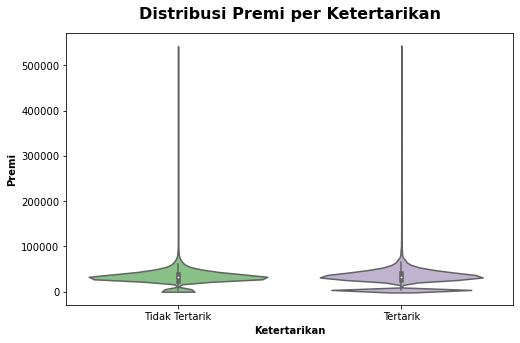

Nilai skewness umur :  1.77 . Artinya, distribusi bersifat severe positive skewness.

Asumsi normalitas distribusi data tidak terpenuhi. Maka itu, korelasi menggunakan metode Spearman :


,Annual_Premium,Response
Annual_Premium,1.000000,0.033991
Response,0.033991,1.000000


In [17]:
# Hubungan antara premi dan ketertarikan
plt.figure(figsize = (8, 5))
ax = sns.violinplot(x = data["Response"], y = data["Annual_Premium"], palette = "Accent")
plt.title("Distribusi Premi per Ketertarikan", fontdict = {'fontsize': 16,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.03)
plt.ylabel("Premi", fontdict = {"weight" : "bold"})
plt.xlabel("Ketertarikan", fontdict = {"weight" : "bold"})
ax.set_xticklabels(["Tidak Tertarik", "Tertarik"])

plt.show()

# Nilai korelasi antara premi dan ketertarikan
print("Nilai skewness umur : ", round(skew(data["Annual_Premium"]), 2), ". Artinya, distribusi bersifat severe positive skewness.")
print("\nAsumsi normalitas distribusi data tidak terpenuhi. Maka itu, korelasi menggunakan metode Spearman :")
display(data[["Annual_Premium", "Response"]].corr("spearman"))

Variabel premi secara tunggal bisa dikatakan tidak memiliki korelasi dengan ketertarikan pelanggan. Pertama, bisa kita lihat dari _violin plot_ yang menunjukkan sentralisasi data yang sama untuk kedua keputusan pelanggan. Kedua, nilai korelasi hampir bernilai 0.

Oleh karenanya, kedua variabel di atas dikombinasikan untuk dicoba dicari hubungannya.

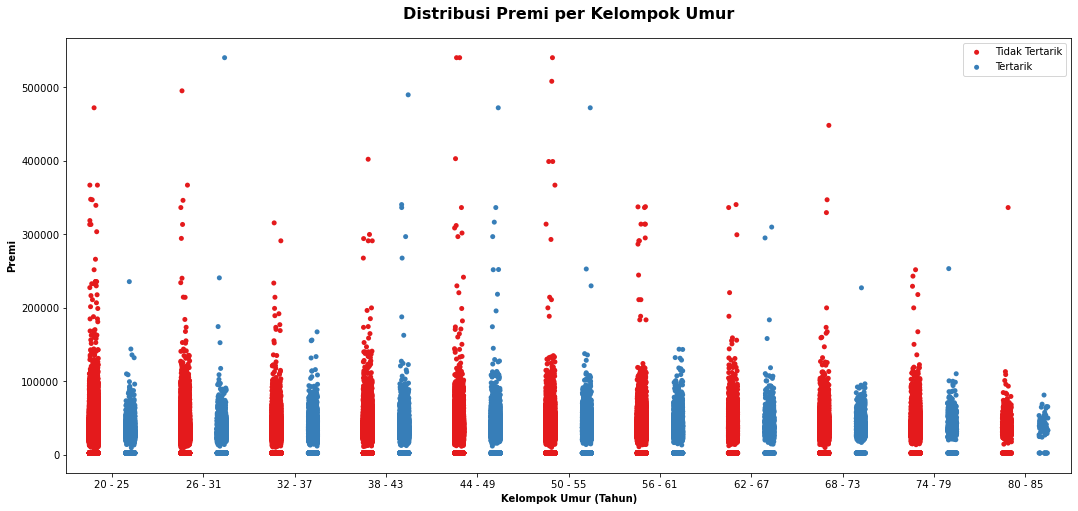

In [18]:
# Hubungan antara premi dan kelompok umur per ketertarikan
plt.figure(figsize = (18, 8))
sns.stripplot(data.sort_values("ageRange", ascending = True)["ageRange"], data.sort_values("ageRange", ascending = True)["Annual_Premium"], palette = "Set1", hue = data["Response"], dodge = True)
plt.title("Distribusi Premi per Kelompok Umur", fontdict = {'fontsize': 16,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.03)
plt.ylabel("Premi", fontdict = {"weight" : "bold"})
plt.xlabel("Kelompok Umur (Tahun)", fontdict = {"weight" : "bold"})
plt.legend(["Tidak Tertarik", "Tertarik"])

plt.show()

Dapat dilihat bahwa semakin tinggi kelompok umur dan semakin tinggi nilai preminya, maka kecenderungan pelanggan untuk tertarik semakin tinggi dengan puncaknya di umur sekitar 38 - 49 tahun. Hal tersebut diikuti dengan penurunan jumlah pelanggan yang tidak tertarik. Namun, tren ini hanya berlaku bagi pelanggan berumur sekitar 20 - 49 tahun. Pola menjadi terbalik memasuki umur 50an hingga kelompok umur terakhir. Sekali lagi, kemungkinan faktor terkuatnya adalah penghasilan.

Nilai skewness jenis kelamin :  -0.16 . Artinya, distribusi masih tergolong normal.


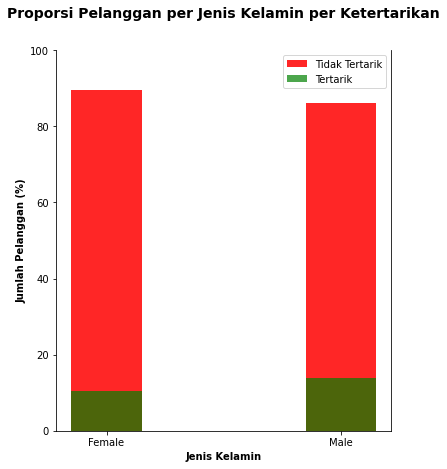

In [19]:
# Hubungan antara jenis kelamin dengan ketertarikan
# Nilai korelasi antara jenis kelamin dengan ketertarikan
print("Nilai skewness jenis kelamin : ", round(skew(data["genderInt"]), 2), ". Artinya, distribusi masih tergolong normal.")
# Distribusi jenis kelamin per ketertarikan
genderPerc = pd.crosstab(data["Gender"], data["Response"], normalize = "index") * 100

# Memakai subplots karena ingin membuang frame bagian atas
fig, ax = plt.subplots(figsize = (6,7))
ax.spines["top"].set_visible(False)
plt.bar(genderPerc.index, genderPerc[0],
       color = "red",
       alpha = 0.85,
       width = 0.3,
       linewidth = 1)

plt.bar(genderPerc.index, genderPerc[1],
       color = "green",
       alpha = 0.7,
       width = 0.3,
       linewidth = 1)
plt.legend(("Tidak Tertarik", "Tertarik"))
plt.ylim(0, 100)
plt.title("Proporsi Pelanggan per Jenis Kelamin per Ketertarikan", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.07)
plt.xlabel("Jenis Kelamin", fontdict = {"weight" : "bold"})
plt.ylabel("Jumlah Pelanggan (%)", fontdict = {"weight" : "bold"})

plt.show()

Pelanggan pria lebih banyak yang tertarik dibandingkan dengan pelanggan wanita. Kemungkinan besar, hal ini dipengaruhi oleh sifat alamiah pria yang lebih peduli terhadap bidang otomotif.

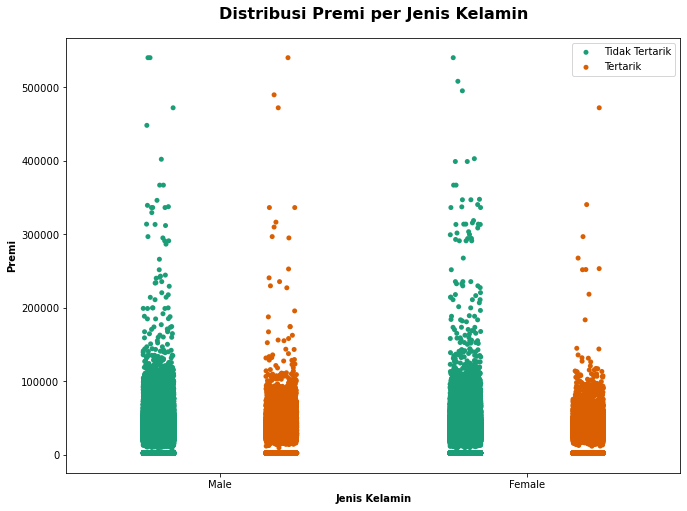

In [20]:
# Hubungan antara premi dan kelompok umur per ketertarikan
plt.figure(figsize = (11, 8))
sns.stripplot(data["Gender"], data["Annual_Premium"], palette = "Dark2", hue = data["Response"], dodge = True)
plt.title("Distribusi Premi per Jenis Kelamin", fontdict = {'fontsize': 16,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.03)
plt.ylabel("Premi", fontdict = {"weight" : "bold"})
plt.xlabel("Jenis Kelamin", fontdict = {"weight" : "bold"})
plt.legend(("Tidak Tertarik", "Tertarik"))

plt.show()

Lebih spesifik lagi, ternyata pria lebih rela membayar premi yang tinggi untuk asuransi kendaraannya dibanding wanita. Hal ini menandakan bahwa pelanggan pria dengan umur kurang lebih 38 - 49 tahun menjadi target yang cukup potensial.

In [21]:
data[["Response", "Vintage"]].corr()

,Response,Vintage
Response,1.00000,-0.00105
Vintage,-0.00105,1.00000


In [22]:
# Nilai korelasi antara waktu terasosiasi dan ketertarikan
print("Nilai skewness waktu terasosiasi (hari) : ", round(skew(data["Vintage"]), 3), ". Artinya, data terdistribusi dengan normal.")
print("\nAsumsi normalitas distribusi data X terpenuhi. Namun, Y ('Response') tidak terdistribusi dengan normal. Maka dari itu korelasi menggunakan metode Spearman :")
display(data[["Vintage", "Response"]].corr("spearman"))

Nilai skewness waktu terasosiasi (hari) :  0.003 . Artinya, data terdistribusi dengan normal.

Asumsi normalitas distribusi data X terpenuhi. Namun, Y ('Response') tidak terdistribusi dengan normal. Maka dari itu korelasi menggunakan metode Spearman :


,Vintage,Response
Vintage,1.000000,-0.001051
Response,-0.001051,1.000000


Nilai korelasi ini sangat amat kecil. Bisa dikatakan bahwa _Vintage_ tidak memiliki hubungan dengan ketertarikan.

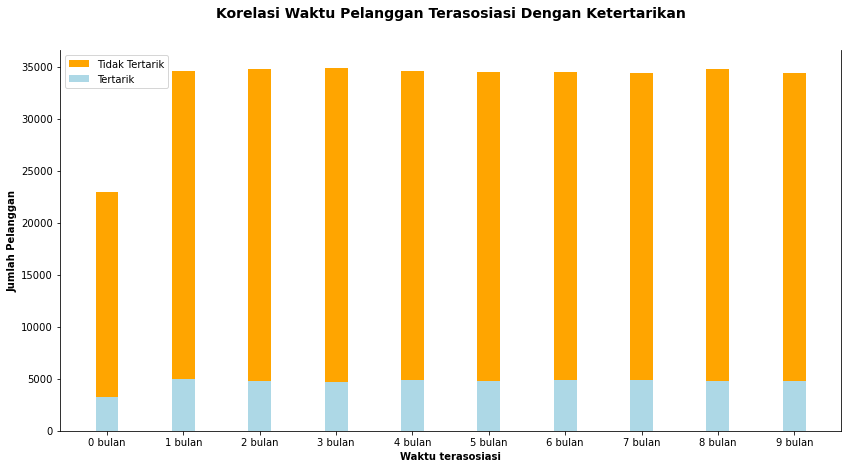

In [23]:
# Distribusi lamanya waktu pelanggan terasosiasi dengan perusahaan (bulan)
vintageMonthResp = pd.crosstab(data["vintageMonth"], data["Response"])

# Memakai subplots karena ingin membuang frame bagian atas
fig, ax = plt.subplots(figsize = (14, 7))
ax.spines["top"].set_visible(False)
plt.bar(data.sort_values("vintageMonth")["vintageMonth"].unique(), vintageMonthResp[0],
       color = "orange",
       width = 0.3,
       linewidth = 1)

plt.bar(data.sort_values("vintageMonth")["vintageMonth"].unique(), vintageMonthResp[1],
       color = "lightblue",
       width = 0.3,
       linewidth = 1)
plt.legend(("Tidak Tertarik", "Tertarik"))
plt.title("Korelasi Waktu Pelanggan Terasosiasi Dengan Ketertarikan", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.07)
plt.xlabel("Waktu terasosiasi", fontdict = {"weight" : "bold"})
plt.ylabel("Jumlah Pelanggan", fontdict = {"weight" : "bold"})

plt.show()

Transformasi data ke bentuk bulan juga ternyata tidak menunjukkan adanya hubungan. Nampak mulai dari 1 - 9 bulan (jumlah data hampir identik) tidak terjadi perubahan pola ketertarikan.

In [24]:
# Distribusi Umur Kendaraan
print("Proporsi umur kendaraan :")
vehicleAgePerc = ((pd.crosstab(data["Vehicle_Age"], columns = "count", normalize = "columns") * 100).round(2)).rename(columns = {"count" : "Presentase"})
vehicleAgePerc.columns.name = ""
vehicleAgePerc.index.name = "Umur Kendaraan"
display(vehicleAgePerc)

Proporsi umur kendaraan :


,Presentase
Umur Kendaraan,
1-2 Year,52.56
< 1 Year,43.24
> 2 Years,4.20


Umur kendaraan di atas 2 tahun jumlahnya sangat amat sedikit. Hal ini seakan menjadikan distribusi data _Vehicle Age_ tidak normal.

In [25]:
# Nilai korelasi antara umur kendaraan dan ketertarikan
print("Nilai skewness umur kendaraan : ", round(skew(data["vehicleAgeInt"]), 2), ". Artinya, sebenarnya data masih bisa dikatakan terdistribusi dengan normal.")
print("\nAsumsi normalitas distribusi data X terpenuhi. Namun, X disini adalah 'ranked value' (umur). Maka dari itu korelasi menggunakan metode Spearman :")
display(data[["vehicleAgeInt", "Response"]].corr("spearman"))

Nilai skewness umur kendaraan :  0.25 . Artinya, sebenarnya data masih bisa dikatakan terdistribusi dengan normal.

Asumsi normalitas distribusi data X terpenuhi. Namun, X disini adalah 'ranked value' (umur). Maka dari itu korelasi menggunakan metode Spearman :


,vehicleAgeInt,Response
vehicleAgeInt,1.000000,0.220621
Response,0.220621,1.000000


Umur kendaraan memiliki nilai korelasi yang tidak terlalu besar dan bersifat linear.

**Semakin tinggi umur kendaraan, maka kecenderungan pelanggan akan tertarik dengan asuransi kendaraan perusahaan.**

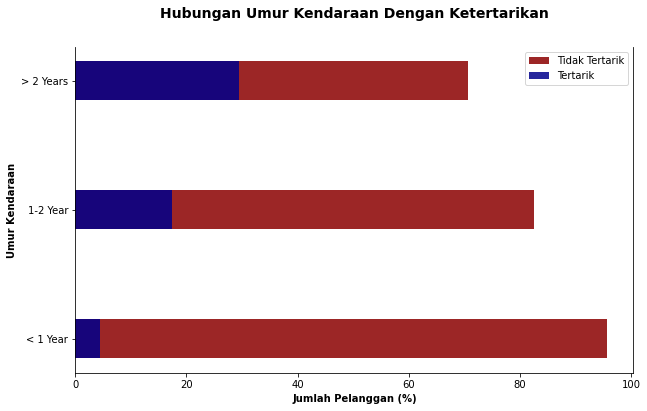

In [26]:
# Korelasi umur kendaraan dengan ketertarikan
# Menggunakan proporsi karena jumlah data setiap nilai berbeda, terutama untuk kendaraan di atas 2 tahun
vehicleAgeDist = (pd.crosstab(data["Vehicle_Age"], data["Response"], normalize = "index") * 100).reindex(["< 1 Year", "1-2 Year", "> 2 Years"])

# Memakai subplots karena ingin membuang frame bagian atas
fig, ax = plt.subplots(figsize = (10, 6))
ax.spines["top"].set_visible(False)
plt.barh(vehicleAgeDist.index, vehicleAgeDist[0],
       color = "darkred",
       alpha = 0.85,
       height = 0.3,
       linewidth = 1)

plt.barh(vehicleAgeDist.index, vehicleAgeDist[1],
       color = "darkblue",
       alpha = 0.85, 
       height = 0.3,
       linewidth = 1)
plt.legend(("Tidak Tertarik", "Tertarik"))
plt.title("Hubungan Umur Kendaraan Dengan Ketertarikan", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.07)
plt.ylabel("Umur Kendaraan", fontdict = {"weight" : "bold"})
plt.xlabel("Jumlah Pelanggan (%)", fontdict = {"weight" : "bold"})

plt.show()

Nilai korelasi di atas terbukti melalui grafik. Semakin tua umur kendaraan pelanggan, maka semakin besar juga ketertarikannya untuk memiliki asuransi kendaraan perusahaan. Kemungkinan besar pelanggan yang umur kendaraannya masih di bawa satu tahun belum merasakan kendala yang cukup berarti bagi kendarannya, mengingat kondisi masih sangat baru, sehingga tidak terlalu tertarik untuk mengambil asuransi. Sebaliknya, kendaraan yang umurnya makin tua akan semakin besar juga peluanganya mengalami kerusakan atau permasalahan. Dengan demikian mengambil asuransi adalah salah satu jalan untuk mengantisipasi kerugian.

In [27]:
# Nilai korelasi antara kerusakan kendaraan dan ketertarikan
print("Nilai skewness kerusakan kendaraan : ", round(skew(data["vehicleDamageInt"]), 3), ". Artinya, data terdistribusi dengan normal.")
print("\nAsumsi normalitas distribusi data X terpenuhi. Namun, X tidak bersifat kontinu. Maka dari itu korelasi menggunakan metode Spearman :")
display(data[["vehicleDamageInt", "Response"]].corr("spearman"))

Nilai skewness kerusakan kendaraan :  -0.02 . Artinya, data terdistribusi dengan normal.

Asumsi normalitas distribusi data X terpenuhi. Namun, X tidak bersifat kontinu. Maka dari itu korelasi menggunakan metode Spearman :


,vehicleDamageInt,Response
vehicleDamageInt,1.0000,0.3544
Response,0.3544,1.0000


Kerusakan kendaraan pelanggan pada waktu - waku sebelumnya ternyata memiliki korelasi yang cukup kuat dengan ketertarikan, bahkan melebihi variabel umur kendaraan itu sendiri.

**Jika pelanggan pernah mengalami kerusakan kendaraan di masa sebelumnya, maka kecenderungan mereka akan tertarik dengan asuransi kendaraan perusahaan pun semakin besar.**

KETERANGAN :
'vehicleAgeInt' = 0 adalah umur kendaraan < 1 tahun
'vehicleAgeInt' = 1 adalah umur kendaraan 1 - 2 tahun
'vehicleAgeInt' = 2 adalah umur kendaraan > 2 tahun



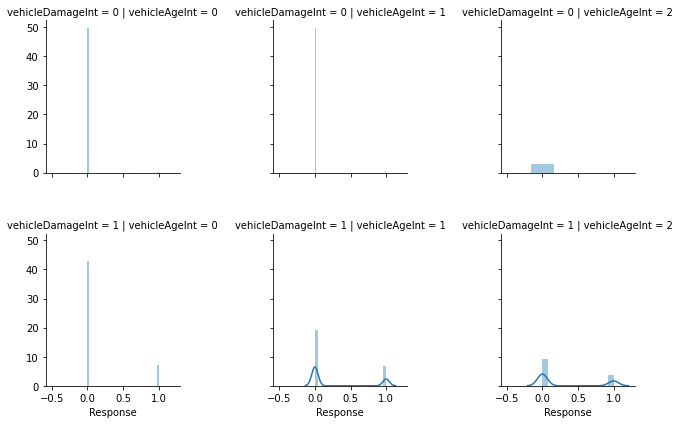

In [28]:
# Hubungan antara umur kendaraan, kerusakan kendaraan, dan ketertarikan
print('''KETERANGAN :
'vehicleAgeInt' = 0 adalah umur kendaraan < 1 tahun
'vehicleAgeInt' = 1 adalah umur kendaraan 1 - 2 tahun
'vehicleAgeInt' = 2 adalah umur kendaraan > 2 tahun\n''')
triCorr = sns.FacetGrid(data, row = "vehicleDamageInt", col = "vehicleAgeInt")
triCorr.map(sns.distplot, "Response")
plt.subplots_adjust(hspace = 0.4, wspace = 0.7)

plt.show()

Pengalaman kerusakan kendaraan ternyata memberi pengaruh yang cukup kuat. Dapat dilihat bahwa tidak peduli berapa tahun umur kendaraan pelanggan, namun bila ia tidak pernah mengalamai kerusakan sebelumnya maka kemungkinan ia untuk tertarik sangat amat kecil. Sebaliknya, bila ia pernah mengalamai kerusakan kendaraan, maka berapapun umur kendaraannya kecenderungan untuk tertarik semakin besar.

**Jika poin kerusakan pelanggan terpenuhi, maka disinilah variabel umur kendaraan memainkan perannya. Semakin tinggi umur tersebut, maka semakin tinggi juga kecenderungan pelanggan untuk tertarik.**

# Modelling

## Feature Selection

Pemilihan variabel independen didasarkan dari hasil analisis EDA. Disimpulkan bahwa variabel yang pantas untuk masuk ke ranah _modelling_ adalah **_genderInt_**, ***Previously_Insured***, **_vehicleAgeInt_**, **_vehicleDamageInt_**, ***Annual_Premium***, dan **_Age_**

In [29]:
# Mengambil variabel relevan
X = data[["genderInt", "Previously_Insured", "vehicleAgeInt", "vehicleDamageInt", "Annual_Premium", "Age"]]
y = data["Response"]

## Base Model

_Base Model_ digunakan untuk melihat algoritma mana yang kira - kira **mempunyai potensi cukup bagus** untuk memprediksi data. Nantinya, model yang punya potensi bagus itulah yang selanjutnya akan disesuaikan agar hasilnya lebih maksimal.

### Preparation

In [30]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 7)

In [63]:
# # Algorithms
# # Logistic Regression
# LogReg = LogisticRegression().fit(X_train, y_train)
# LogRegPredTrain = LogReg.predict(X_train)
# LogRegPredTest = LogReg.predict(X_test)

# # Random Forest Classifier
# RanFor = RandomForestClassifier().fit(X_train, y_train)
# RanForPredTrain = RanFor.predict(X_train)
# RanForPredTest = RanFor.predict(X_test)

# # Support Vector Machine Classifier
# SVM = SVC().fit(X_train, y_train)
# SVMPredTrain = SVM.predict(X_train)
# SVMPredTest = SVM.predict(X_test)

# # K - Nearest Neighbors Classifier
# KNN = KNeighborsClassifier().fit(X_train, y_train)
# KNNPredTrain = KNN.predict(X_train)
# KNNPredTest = KNN.predict(X_test)

# # Extreme Gradient Boosting Classifier
# XGB = XGBClassifier().fit(X_train, y_train)
# XGBPredTrain = XGB.predict(X_train)
# XGBPredTest = XGB.predict(X_test)

### Evaluation Metrics

Metrik Evaluasi Data Uji Logistic Regression :


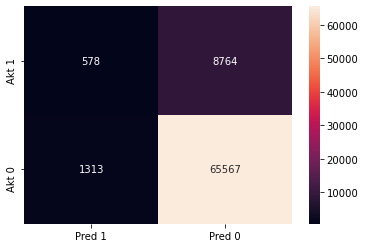


Metrik Evaluasi Data Uji Random Forest :


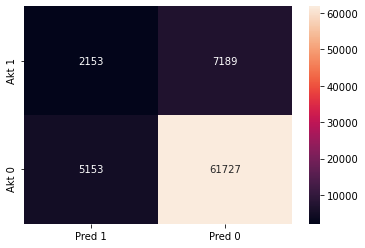


Metrik Evaluasi Data Uji SVM Classifier :


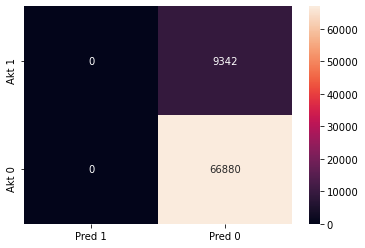


Metrik Evaluasi Data Uji KNN Classifier :


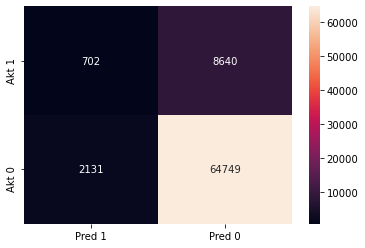


Metrik Evaluasi Data Uji XGBoost Classifier :


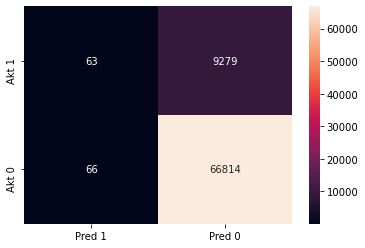

In [92]:
# Logistic Regression
conMatLogReg = confusion_matrix(y_test, LogRegPredTest, labels = [1, 0])
conMatLogReg = pd.DataFrame(conMatLogReg, index = ["Akt 1", "Akt 0"], columns = ["Pred 1", "Pred 0"])
sns.heatmap(conMatLogReg, annot = True, fmt = 'g')
print("Metrik Evaluasi Data Uji Logistic Regression :")
plt.show()

# Random Forest Classifier
conMatRanFor = confusion_matrix(y_test, RanForPredTest, labels = [1, 0])
conMatRanFor = pd.DataFrame(conMatRanFor, index = ["Akt 1", "Akt 0"], columns = ["Pred 1", "Pred 0"])
sns.heatmap(conMatRanFor, annot = True, fmt = 'g')
print("\nMetrik Evaluasi Data Uji Random Forest :")
plt.show()

# Support Vector Machine Classifier
conMatSVM = confusion_matrix(y_test, SVMPredTest, labels = [1, 0])
conMatSVM = pd.DataFrame(conMatSVM, index = ["Akt 1", "Akt 0"], columns = ["Pred 1", "Pred 0"])
sns.heatmap(conMatSVM, annot = True, fmt = 'g')
print("\nMetrik Evaluasi Data Uji SVM Classifier :")
plt.show()

# K - Nearest Neighbors Classifier
conMatKNN = confusion_matrix(y_test, KNNPredTest, labels = [1, 0])
conMatKNN = pd.DataFrame(conMatKNN, index = ["Akt 1", "Akt 0"], columns = ["Pred 1", "Pred 0"])
sns.heatmap(conMatKNN, annot = True, fmt = 'g')
print("\nMetrik Evaluasi Data Uji KNN Classifier :")
plt.show()

# Extreme Gradient Boosting Classifier
conMatXGB = confusion_matrix(y_test, XGBPredTest, labels = [1, 0])
conMatXGB = pd.DataFrame(conMatXGB, index = ["Akt 1", "Akt 0"], columns = ["Pred 1", "Pred 0"])
sns.heatmap(conMatXGB, annot = True, fmt = 'g')
print("\nMetrik Evaluasi Data Uji XGBoost Classifier :")
plt.show()

Dalam kasus ini, _error_ yang harus diminimalisir adalah ***False Negative***. Akan lebih merugikan jika mesin memprediksi pelanggan tidak tertarik, namun aktualnya ia tertarik. Sebaliknya, toleransi bisa diberikan pada _False Positive_ (mesin memprediksi pelanggan tertarik, namun aktualnya ia tidak tertarik).

**Jika FN besar, maka perusahaan akan kehilangan pelanggan potensialnya. Kemungkinan terburuk, pelanggan tersebut bisa diambil oleh perusahaan asuransi kendaraan lainnya. Akan tetapi, bila FP tinggi, kerugian yang dialami oleh perusahaan hanya sebatas waktu (untuk menghubungi) dan sedikit materi (tergantung pada tipe pendekatan). Maka itu, evaluasi yang digunakan adalah _Recall_. Alasan lainnya adalah terkait distribusi target yang tidak seimbang, sehingga tidak memungkinkan untuk memakai _accuracy_.**

Dari kelima model standar di atas, **_Random Forest_** adalah model terbaik karena ia mampu menekan angka FP. Bahkan, jumlahnya sangat jauh dibanding keempat model lain yang jumlahnya di atas 8.600 pelanggan. Meskipun begitu, model dasar ini dirasa tidak cukup fair mengingat bentuk data yang **tidak seimbang**. Oleh karena itu data akan diberi penyesuaian terlebih dahulu dengan metode ***Random Over Sampling***.

***Handling Imbalanced Data***

In [99]:
# 'Tidak Tertarik' (0) adalah mayoritas. Sedangkan, 'Tertarik' (1) adalah minoritas.
dataTrain = pd.concat([X_train, y_train], axis = 1)
noResponse, yesResponse = dataTrain[dataTrain["Response"] == 0], dataTrain[dataTrain["Response"] == 1]
yesOverSampled = resample(yesResponse, replace = True, n_samples = len(noResponse), random_state = 7)

dataTrainOverSampled = pd.concat([noResponse, yesOverSampled])

print("Data latih yang sudah di sampling ulang :")
display(dataTrainOverSampled.groupby("Response").count()[["genderInt"]].rename(columns = {"genderInt" : "Jumlah"}))

Data latih yang sudah di sampling ulang :


,Jumlah
Response,
0,267519
1,267519


***Re - Training and Modelling***

In [ ]:
# Algorithms
X_trainOS, y_trainOS = dataTrainOverSampled.drop("Response", 1), dataTrainOverSampled["Response"]

# # Logistic Regression
LogRegOS = LogisticRegression().fit(X_trainOS, y_trainOS)
LogRegPredTrainOS = LogRegOS.predict(X_train)
LogRegPredTestOS = LogRegOS.predict(X_test)

# Random Forest Classifier
RanForOS = RandomForestClassifier().fit(X_trainOS, y_trainOS)
RanForPredTrainOS = RanForOS.predict(X_train)
RanForPredTestOS = RanForOS.predict(X_test)

# Support Vector Machine Classifier
SVMOS = SVC().fit(X_trainOS, y_trainOS)
SVMPredTrainOS = SVMOS.predict(X_train)
SVMPredTestOS = SVMOS.predict(X_test)

# K - Nearest Neighbors Classifier
KNNOS = KNeighborsClassifier().fit(X_trainOS, y_trainOS)
KNNPredTrainOS = KNNOS.predict(X_train)
KNNPredTestOS = KNNOS.predict(X_test)

# Extreme Gradient Boosting Classifier
XGBOS = XGBClassifier().fit(X_trainOS, y_trainOS)
XGBPredTrainOS = XGBOS.predict(X_train)
XGBPredTestOS = XGBOS.predict(X_test)

**Proses dihentikan secara paksa setelah kurang lebih 4 jam berjalan. Diputuskan untuk tidak melanjutkan _base model_ dengan data _over sampling_ ini karena kondisi dan performa laptop yang tidak mendukung.**

Proses selanjutnya langsung memasuki _tuning_ model, dimana hanya 3 model dengan jumlah FN terendah yang akan diproses. Mereka adalah *Logistic Regression*, *Random Forest Classifier*, dan *KNN Classifier*.

## Tuned Model

### Logistic Regression

***Hyper Parameter Tuning***

In [73]:
LogRegTuned = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid = {
        "penalty" : ["l1", "l2", "elasticnet"],
        "class_weight" : [None, {0 : 0.2, 1 : 0.8}, {0 : 0.08, 1 : 0.92}],
        "random_state" : [77],
        "max_iter" : [100, 300, 500],
        "warm_start" : [True, False],
        "solver" : ["lbfgs", "saga", "sag"]
        }, cv = 4, n_jobs = -1, verbose = 1
    )

LogRegTuned.fit(X_train, y_train)

Fitting 4 folds for each of 162 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 46.4min finished


GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [None, {0: 0.2, 1: 0.8},
                                          {0: 0.08, 1: 0.92}],
                         'max_iter': [100, 300, 500],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'random_state': [77],
                         'solver': ['lbfgs', 'saga', 'sag'],
                         'warm_start': [True, False]},
             verbose=1)

In [74]:
# Best Param
print("Parameter terbaik dari Logistic Regression - Tuned:")
display(LogRegTuned.best_params_)

Parameter terbaik dari Logistic Regression - Tuned:


{'class_weight': None,
 'max_iter': 100,
 'penalty': 'l1',
 'random_state': 77,
 'solver': 'saga',
 'warm_start': True}

Metrik Evaluasi Data Uji Logistic Regression - Tuned :


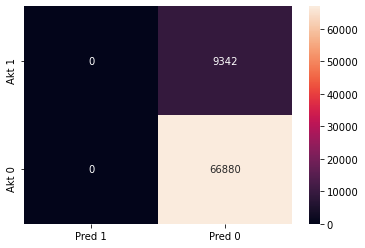

In [80]:
# Evaluation Metrics
bestLogRegTuned = LogRegTuned.best_estimator_
LogRegTunedPredTest = bestLogRegTuned.predict(X_test)

conMatLogRegTuned = confusion_matrix(y_test, LogRegTunedPredTest, labels = [1, 0])
conMatLogRegTuned = pd.DataFrame(conMatLogRegTuned, index = ["Akt 1", "Akt 0"], columns = ["Pred 1", "Pred 0"])
sns.heatmap(conMatLogRegTuned, annot = True, fmt = 'g')
print("Metrik Evaluasi Data Uji Logistic Regression - Tuned :")
plt.show()

### Random Forest Classifier

In [ ]:
RanForTuned = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = {
        "n_estimators" : [100, 200, 500],
        "max_depth" : [None, 5, 7],
        "min_samples_split" : [2, 9, 10],
        "min_samples_leaf" : [1, 2, 5],
        "max_features" : [None, 3, 5]
        }, cv = 4, n_jobs = -1, verbose = 1
    )

RanForTuned.fit(X_train, y_train)

Fitting 4 folds for each of 243 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 58.0min


**Laptop tidak bisa memproses setelah berjalan hampir 3,5 jam. Diputuskan untuk menyudahi proses karena performa laptop juga ikut menurun (*lagging*).**